<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/3.2-biLSTMB16-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiDirectional 16 Cell LSTM Prototype (Balanced Weights)

16 cell 1 layer BiDirectional LSTM network with balanced weights

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru



import random

# fix random seeds
RSTATE = 1
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(RSTATE)
random.seed(RSTATE)
np.random.seed(RSTATE)


logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False


SAMPLES = "200k"
LSTM_DIM = 16 # total LSTM units
REPORT_FILE = "dl_prototype-report.csv"

# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.0
RECURRENT_DROPOUT_RATE = 0.0


# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100


MODEL_NAME = f"LSTMB{LSTM_DIM}"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer Bidirectional {LSTM_DIM} LSTM Units, balanced weights"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 4


if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
  ku.ModelWrapper.set_report_filename(f'test-{REPORT_FILE}')
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename(REPORT_FILE)


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'


start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[FEATURE_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=49573
Number of Documents=149653
Train review vectors shape: (149653, 100)  Test review vectors shape: (49885, 100)


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts)+1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(LSTM_DIM, dropout = DROPOUT_RATE, recurrent_dropout= RECURRENT_DROPOUT_RATE)))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          14872200  
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                40576     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 14,912,941
Trainable params: 14,912,941
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                             restore_best_weights = True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1,
                           restore_best_weights = True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
weights_dict = {i: weights[i] for i in np.arange(0, len(weights))}
print(f'class weights: {weights}')
print(f'class weights_dict: {weights_dict}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN,
                     FEATURE_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights_dict,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.43769724 3.07691596 2.18277088 1.19627098 0.37238702]
class weights_dict: {0: 1.4376972404351898, 1: 3.076915959907479, 2: 2.182770880052508, 3: 1.1962709832134293, 4: 0.372387022124348}
Number of training examples: 149653
Epoch 1/20
936/936 [==============================] - 102s 109ms/step - loss: 1.1918 - categorical_accuracy: 0.5712 - val_loss: 1.0861 - val_categorical_accuracy: 0.5692 - lr: 0.0100
Epoch 2/20
936/936 [==============================] - 100s 107ms/step - loss: 1.0694 - categorical_accuracy: 0.6180 - val_loss: 1.0505 - val_categorical_accuracy: 0.5738 - lr: 0.0100
Epoch 3/20
936/936 [==============================] - 94s 100ms/step - loss: 1.0350 - categorical_accuracy: 0.6287 - val_loss: 1.0594 - val_categorical_accuracy: 0.5573 - lr: 0.0100
Epoch 4/20
936/936 [==============================] - 94s 101ms/step - loss: 1.0143 - categorical_accuracy: 0.6372 - val_loss: 1.0486 - val_categorical_accuracy: 0.5827 - lr: 0.0100
Epoch 5/20
936/936 [=========

Number of test: 49885
Running model.evaluate...
1559/1559 [==============================] - 11s 7ms/step - loss: 1.0501 - categorical_accuracy: 0.5802
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(49885, 5)
Getting classification report...
Accuracy: 58.02%


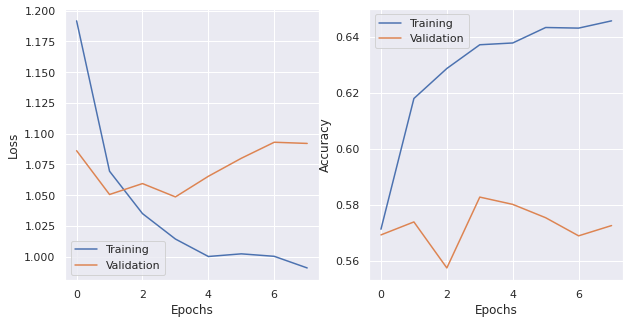


Confusion Matrix
[[ 4430  1464   705   138   221]
 [ 1021  1024   857   194   137]
 [  553   983  1828   788   402]
 [  265   544  1873  2987  2699]
 [  699   556  1723  5121 18673]]

Classification Report
              precision    recall  f1-score   support

           1       0.64      0.64      0.64      6958
           2       0.22      0.32      0.26      3233
           3       0.26      0.40      0.32      4554
           4       0.32      0.36      0.34      8368
           5       0.84      0.70      0.76     26772

    accuracy                           0.58     49885
   macro avg       0.46      0.48      0.46     49885
weighted avg       0.63      0.58      0.60     49885



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

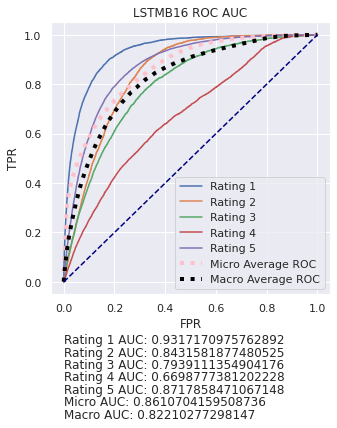

In [8]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.44619582347281606


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB16-1x16-random_embedding-sampling_none-199538-100-review_body
Saving to report file: drive/My Drive/Springboard/capstone//reports/dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone//reports/dl_prototype-report.csv
{'model_name': 'LSTMB16', 'architecture': '1x16', 'description': '1 Layer Bidirectional 16 LSTM Units, balanced weights', 'feature_column': '{"1": {"precision": 0.6357634902411022, "recall": 0.636677206093705, "f1-score": 0.6362200201062761, "support": 6958}, "2": {"precision": 0.2240210019689346, "recall": 0.3167336838849366, "f1-score": 0.26242952332137365, "support": 3233}, "3": {"precision": 0.26166618952190096, "recall": 0.4014053579270971, "f1-score": 0.31681109185441936, "support": 4554}, "4": {"precision": 0.32368877329865625, "recall": 0.3569550669216061, "f1-score": 0.33950897931348034, "support": 8368}, "5": {"precision": 0.8437104644858124, "recall": 0.6974824443448379, "f1-score": 0.7636594143628332, "support": 267

In [11]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


1559/1559 [==============================] - 12s 7ms/step - loss: 1.0501 - categorical_accuracy: 0.5802
Accuracy: 58.02%


In [12]:
  end_time = datetime.now()
  print(f'Report filename: {ku.ModelWrapper.get_report_file_name(DRIVE_DIR, use_date=False)}')
  print(f'Star Time: {start_time }\nEnd time: {end_time}\nTotal Duration: {round((end_time - start_time).total_seconds() / 60, 2)} mins')

Report filename: drive/My Drive/Springboard/capstone//reports/dl_prototype-report.csv
Star Time: 2020-05-02 11:32:47.368613
End time: 2020-05-02 11:46:52.827341
Total Duration: 14.09 mins
